# CYBERML – Analyse du CIC IoT-DIAD 2024

Ce notebook conçoit et évalue une chaîne de traitement batch pour **(i)** la détection d’anomalies (non supervisée) et **(ii)** la classification d’attaques (supervisée), à partir de caractéristiques de flux réseau (flow-based).


## 1. Introduction

Objectif : construire un pipeline reproductible pour des données de flux en cybersécurité, comparer **3 algorithmes non supervisés** et **3 algorithmes supervisés**, et rapporter les métriques requises :
- Matrice de confusion, Précision, Rappel, AUPRC, Balanced accuracy, MCC.

On commence en binaire (**Benign vs Attack**) puis on augmente progressivement la diversité des attaques.


In [42]:
import os
import random
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    average_precision_score,
    balanced_accuracy_score,
    matthews_corrcoef,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

BASE_DIR = "./Device_Identification_Anomaly_Detection-Packet_Based_Features"
TARGET_FAMILIES = ["Benign", "BruteForce", "DDoS", "DoS", "Mirai", "Recon", "Spoofing", "Web-Based"]
DROP_CANDIDATES = {"Flow ID","Src IP","Dst IP","Src Port","Dst Port","Timestamp","Unnamed: 0"}
DROP_PATTERNS = ["source ip", "destination ip", "src ip", "dst ip", "port", "timestamp", "flow id"]
CANONICAL_FAMILY = {
    "benign": "Benign",
    "benigntraffic": "Benign",
    "ddos": "DDoS",
    "dos": "DoS",
    "mirai": "Mirai",
    "recon": "Recon",
    "spoofing": "Spoofing",
    "webbased": "Web-Based",
    "bruteforce": "BruteForce",
}

MAX_ROWS_PER_FAMILY = 3_000
MAX_ROWS_PER_SUBTYPE = 10_000
MAX_ROWS_BINARY = 50_000

## 2. Jeu de données et protocole expérimental

Jeu de données : **CIC IoT-DIAD 2024 – Anomaly Detection (Flow Based Features)**.

Dans cette version du notebook, on utilise **toutes les attaques** disponibles (dans la limite de budgets RAM-safe) :
- Benign
- BruteForce
- DDoS
- DoS
- Mirai
- Recon
- Spoofing
- Web-Based

Point critique : le split train/test est fait **par fichier (group split)** pour éviter la fuite de données (flows très similaires d’un même PCAP en train et en test).


In [43]:
def should_drop(col: str) -> bool:
    name = col.strip()
    low = name.lower()
    if name in DROP_CANDIDATES and any(p in low for p in DROP_PATTERNS):
        return True
    return False

def infer_family_subtype(csv_path: str):
    rel = os.path.relpath(csv_path, BASE_DIR)
    parts = rel.split(os.sep)
    key = "".join(ch for ch in parts[0].lower() if ch.isalnum())
    family = CANONICAL_FAMILY.get(key, parts[0])
    subtype = parts[1] if len(parts) >= 3 else family
    return family, subtype

def list_all_flow_csvs():
    paths = []
    for root, _, files in os.walk(BASE_DIR):
        for f in files:
            if f.endswith(".csv"):
                paths.append(os.path.join(root, f))
    return sorted(paths)

def eval(y_true, y_pred, y_score, title, y_proba=None, classes=None):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_score_arr = None if y_score is None else np.asarray(y_score)
    y_proba_arr = None if y_proba is None else np.asarray(y_proba)
    if y_proba_arr is None and y_score_arr is not None and y_score_arr.ndim == 2:
        y_proba_arr = y_score_arr

    is_multiclass = False
    if classes is not None:
        is_multiclass = len(classes) > 2
    else:
        is_multiclass = np.unique(y_true).size > 2

    if is_multiclass:
        prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
        rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
        bal_acc = balanced_accuracy_score(y_true, y_pred)
        mcc = matthews_corrcoef(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels=classes)

        auprc = None
        if classes is not None and y_proba_arr is not None and y_proba_arr.ndim == 2:
            Y = label_binarize(y_true, classes=classes)
            present = Y.sum(axis=0) > 0
            if present.any():
                auprc = average_precision_score(Y[:, present], y_proba_arr[:, present], average="macro")
        return {
            "title": title,
            "cm": cm,
            "precision": float(prec),
            "recall": float(rec),
            "auprc": None if auprc is None else float(auprc),
            "balanced_acc": float(bal_acc),
            "mcc": float(mcc),
        }

    # Binaire
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    auprc = None
    if y_score_arr is not None:
        if y_score_arr.ndim == 2 and y_score_arr.shape[1] >= 2:
            auprc = average_precision_score(y_true, y_score_arr[:, 1])
        else:
            auprc = average_precision_score(y_true, y_score_arr.ravel())

    return {
        "title": title,
        "cm": cm,
        "precision": float(prec),
        "recall": float(rec),
        "auprc": None if auprc is None else float(auprc),
        "balanced_acc": float(bal_acc),
        "mcc": float(mcc),
    }


def plot_confusion_matrix(y_true, y_pred_or_score, title, class_names=None):
    y_arr = np.asarray(y_pred_or_score)
    if y_arr.dtype.kind in "fc" and y_arr.ndim == 1:
        y_pred = (y_arr >= 0.5).astype(int)
    else:
        y_pred = y_pred_or_score

    labels = None
    xticklabels = None
    yticklabels = None
    if class_names is not None:
        labels = np.arange(len(class_names))
        xticklabels = class_names
        yticklabels = class_names

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    figsize = (4, 4) if class_names is None or len(class_names) <= 2 else (7, 6)

    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=xticklabels,
        yticklabels=yticklabels,
    )
    plt.title(title)
    plt.ylabel("Réel")
    plt.xlabel("Prédit")
    if class_names is not None and len(class_names) > 2:
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
    plt.show()


In [44]:
def load_all_flows_ram_safe(
    feature_cols: list[str],
    chunksize: int = 200_000,
):
    rng = np.random.default_rng(RANDOM_STATE)

    def _merge_cap(existing, incoming, cap):
        if existing is None or len(existing) == 0:
            combined = incoming
        else:
            combined = pd.concat([existing, incoming], ignore_index=True)
        if len(combined) <= cap:
            return combined
        keep_idx = rng.choice(len(combined), size=cap, replace=False)
        return combined.iloc[keep_idx].reset_index(drop=True)

    csv_paths = list_all_flow_csvs()
    target_families = set(TARGET_FAMILIES)
    target_subtypes = set()
    for p in csv_paths:
        fam, sub = infer_family_subtype(p)
        if fam not in target_families:
            continue
        subtype_label = "Benign" if fam == "Benign" else str(sub)
        target_subtypes.add(subtype_label)

    kept_binary = {"Benign": None, "Attack": None}
    kept_by_family = {}
    kept_by_subtype = {}

    def _binary_full():
        return (
            kept_binary["Benign"] is not None
            and len(kept_binary["Benign"]) >= MAX_ROWS_BINARY
            and kept_binary["Attack"] is not None
            and len(kept_binary["Attack"]) >= MAX_ROWS_BINARY
        )

    def _families_full():
        return all(
            (f in kept_by_family) and (len(kept_by_family[f]) >= MAX_ROWS_PER_FAMILY)
            for f in target_families
        )

    def _subtypes_full():
        return all(
            (s in kept_by_subtype) and (len(kept_by_subtype[s]) >= MAX_ROWS_PER_SUBTYPE)
            for s in target_subtypes
        )

    def _all_full():
        return _binary_full() and _families_full() and _subtypes_full()

    for p in tqdm.tqdm(csv_paths):
        if _all_full():
            break

        fam, sub = infer_family_subtype(p)
        if fam not in target_families:
            continue

        binary_label = "Benign" if fam == "Benign" else "Attack"
        subtype_label = "Benign" if fam == "Benign" else str(sub)
        group = os.path.relpath(p, BASE_DIR)

        fam_full = fam in kept_by_family and len(kept_by_family[fam]) >= MAX_ROWS_PER_FAMILY
        subtype_full = subtype_label in kept_by_subtype and len(kept_by_subtype[subtype_label]) >= MAX_ROWS_PER_SUBTYPE
        binary_full = kept_binary[binary_label] is not None and len(kept_binary[binary_label]) >= MAX_ROWS_BINARY
        if fam_full and subtype_full and binary_full:
            continue

        header_cols = set(pd.read_csv(p, nrows=0).columns)
        usecols = [c for c in feature_cols if c in header_cols]
        has_feature_overlap = True
        if not usecols:
            has_feature_overlap = False
            fallback_cols = [c for c in header_cols if (c != "Label") and (not should_drop(c))]
            if not fallback_cols:
                continue
            usecols = [sorted(fallback_cols)[0]]

        for chunk in pd.read_csv(p, usecols=usecols, chunksize=chunksize, low_memory=False):
            if _all_full():
                break

            fam_full = fam in kept_by_family and len(kept_by_family[fam]) >= MAX_ROWS_PER_FAMILY
            subtype_full = subtype_label in kept_by_subtype and len(kept_by_subtype[subtype_label]) >= MAX_ROWS_PER_SUBTYPE
            binary_full = kept_binary[binary_label] is not None and len(kept_binary[binary_label]) >= MAX_ROWS_BINARY
            if fam_full and subtype_full and binary_full:
                break

            for c in chunk.columns:
                chunk[c] = pd.to_numeric(chunk[c], errors="coerce", downcast="float")
            chunk = chunk.replace([np.inf, -np.inf], np.nan)
            if has_feature_overlap:
                chunk = chunk.dropna(axis=0, how="all")
                if len(chunk) == 0:
                    continue

            chunk["attack_family"] = fam
            chunk["attack_subtype"] = "Benign" if fam == "Benign" else str(sub)
            chunk["group"] = group

            if not fam_full:
                kept_by_family[fam] = _merge_cap(kept_by_family.get(fam), chunk, MAX_ROWS_PER_FAMILY)
            if not subtype_full:
                kept_by_subtype[subtype_label] = _merge_cap(kept_by_subtype.get(subtype_label), chunk, MAX_ROWS_PER_SUBTYPE)
            if not binary_full:
                kept_binary[binary_label] = _merge_cap(kept_binary.get(binary_label), chunk, MAX_ROWS_BINARY)

    def _finalize(df):
        if df is None:
            df = pd.DataFrame()
        for c in feature_cols:
            if c not in df.columns:
                df[c] = np.nan
        for c in ["attack_family", "attack_subtype", "group"]:
            if c not in df.columns:
                df[c] = np.nan
        return df

    binary_frames = [d for d in [kept_binary["Benign"], kept_binary["Attack"]] if d is not None]
    df_binaire = pd.concat(binary_frames, ignore_index=True) if binary_frames else pd.DataFrame()
    df_familles = pd.concat(list(kept_by_family.values()), ignore_index=True) if kept_by_family else pd.DataFrame()
    df_st = pd.concat(list(kept_by_subtype.values()), ignore_index=True) if kept_by_subtype else pd.DataFrame()

    return _finalize(df_binaire), _finalize(df_familles), _finalize(df_st)


all_csvs = list_all_flow_csvs()
all_cols_set = set()
for p in tqdm.tqdm(all_csvs, desc="Scan headers"):
    all_cols_set.update(pd.read_csv(p, nrows=0).columns)
all_cols = sorted(all_cols_set)
drop_cols = [c for c in all_cols if should_drop(c)]
feature_cols_common = [c for c in all_cols if (c not in drop_cols) and c != "Label"]

df_binaire, df_familles, df_st = load_all_flows_ram_safe(feature_cols_common,100_000)


100%|██████████| 180/180 [01:52<00:00,  1.60it/s]


In [45]:
def prepare_scenario(df: pd.DataFrame, feature_cols: list[str], name: str):
    df_used = df
    if name == "Binaire":
        classes = ["Benign", "Attack"]
        y = (df_used["attack_family"] != "Benign").astype(np.int8).to_numpy()
    elif name == "Familles":
        classes = sorted(df_used["attack_family"].astype(str).unique())
        family_to_id = {f: i for i, f in enumerate(classes)}
        y = df_used["attack_family"].map(family_to_id).astype(np.int16).to_numpy()
    else:
        df_used = df_used.copy()
        df_used.loc[df_used["attack_family"] == "Benign", "attack_subtype"] = "Benign"
        df_used["subtype_filtered"] = df_used["attack_subtype"].astype(str)
        classes = sorted(df_used["subtype_filtered"].astype(str).unique())
        subtype_to_id = {s: i for i, s in enumerate(classes)}
        y = df_used["subtype_filtered"].map(subtype_to_id).astype(np.int16).to_numpy()

    X_raw = np.nan_to_num(df_used[feature_cols].to_numpy(dtype=np.float32), nan=0.0, posinf=0.0, neginf=0.0)
    train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=RANDOM_STATE, stratify=y)
    X_train, X_test = X_raw[train_idx], X_raw[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler(with_mean=True, with_std=True)
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    return {
        "name": name,
        "X_train": X_train_s,
        "X_test": X_test_s,
        "y_train": y_train,
        "y_test": y_test,
        "classes": classes,
    }
binary_scenario = prepare_scenario(df_binaire, feature_cols_common, name="Binaire")
family_scenario = prepare_scenario(df_familles, feature_cols_common, name="Familles")
st_scenario = prepare_scenario(df_st, feature_cols_common, name="Sous-types")


## 5. Expériences de détection d’anomalies

Les modèles non supervisés sont entraînés **uniquement sur le trafic Benign** puis évalués sur l’ensemble du test.
On rapporte les métriques et on trace une matrice de confusion (Figure 4).


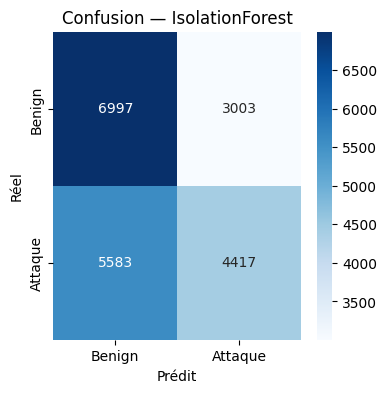

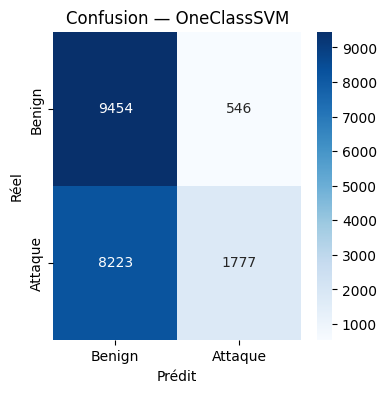

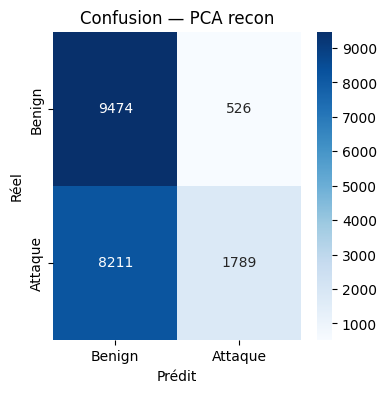

,scenario,title,precision,recall,auprc,balanced_acc,mcc
0,Binaire,Non supervisé - IsolationForest,0.595283,0.4417,0.572784,0.57070,0.146355
1,Binaire,Non supervisé - OneClassSVM,0.764959,0.1777,0.663031,0.56155,0.192101
2,Binaire,Non supervisé - PCA recon,0.772786,0.1789,0.798270,0.56315,0.197390


In [46]:
results = []
artifacts = {}


contam = float(np.clip(float(np.mean(binary_scenario["y_train"])), 0.01, 0.30))
iso = IsolationForest(n_estimators=300, contamination=contam, random_state=RANDOM_STATE, n_jobs=-1)
iso.fit(binary_scenario["X_train"][binary_scenario["y_train"] == 0])
iso_pred = (iso.predict(binary_scenario["X_test"]) == -1).astype(int)
iso_score = -iso.score_samples(binary_scenario["X_test"])


oc = OneClassSVM(kernel="rbf", nu=0.05, gamma="scale")
oc.fit(binary_scenario["X_train"][binary_scenario["y_train"] == 0])
oc_pred = (oc.predict(binary_scenario["X_test"]) == -1).astype(int)
oc_score = -oc.decision_function(binary_scenario["X_test"])


pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
pca.fit(binary_scenario["X_train"][binary_scenario["y_train"] == 0])
recon_error = np.mean((binary_scenario["X_test"] - pca.inverse_transform(pca.transform(binary_scenario["X_test"]))) ** 2, axis=1)
train_recon_error = np.mean((binary_scenario["X_train"][binary_scenario["y_train"] == 0] - pca.inverse_transform(pca.transform(binary_scenario["X_train"][binary_scenario["y_train"] == 0]))) ** 2, axis=1)
pca_pred = (recon_error > np.quantile(train_recon_error, 0.95)).astype(int)





results.append(eval(binary_scenario["y_test"], iso_pred, iso_score, title=f"Non supervisé - IsolationForest"))
results.append(eval(binary_scenario["y_test"], oc_pred, oc_score, title=f"Non supervisé - OneClassSVM"))
results.append(eval(binary_scenario["y_test"], pca_pred, recon_error, title=f"Non supervisé - PCA recon"))
for r in results:
	r["scenario"] = binary_scenario["name"]

artifacts["iso_pred"] = iso_pred
artifacts["oc_pred"] = oc_pred
artifacts["pca_pred"] = pca_pred

plot_confusion_matrix(binary_scenario["y_test"], artifacts["iso_pred"],   "Confusion — IsolationForest", class_names=["Benign", "Attaque"])
plot_confusion_matrix(binary_scenario["y_test"], artifacts["oc_pred"],    "Confusion — OneClassSVM", class_names=["Benign", "Attaque"])
plot_confusion_matrix(binary_scenario["y_test"], artifacts["pca_pred"],   "Confusion — PCA recon", class_names=["Benign", "Attaque"])

unsup_df = pd.DataFrame(results)
unsup_df = unsup_df[["scenario", "title", "precision", "recall", "auprc", "balanced_acc", "mcc"]]
unsup_df


## 6. Expériences de classification supervisée

Les modèles supervisés sont entraînés sur des données labellisées **Benign vs Attack** (données chargées dans `df_binaire`).

Le split est fait **par fichier** (GroupShuffleSplit) pour éviter la fuite.
On trace les matrices de confusion (Figure 4) et les courbes précision–rappel (Figure 5).


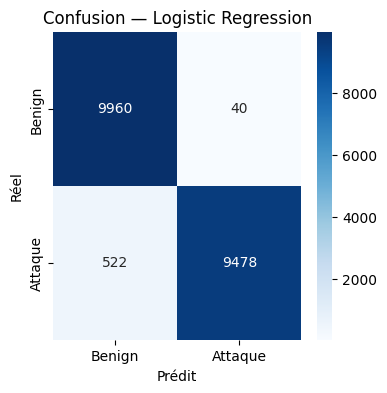

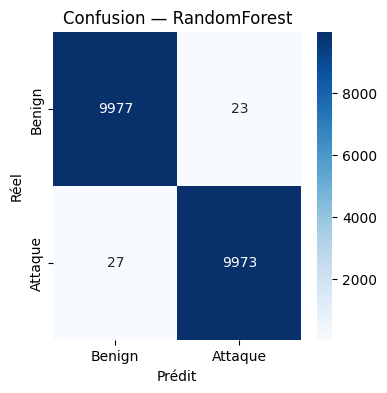

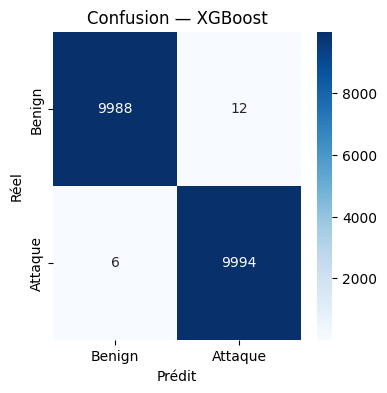

,scenario,title,precision,recall,auprc,balanced_acc,mcc
0,Binaire,Régression logistique,0.995797,0.9478,0.993314,0.9719,0.944898
1,Binaire,RandomForest,0.997699,0.9973,0.999978,0.9975,0.995000
2,Binaire,XGBoost,0.998801,0.9994,0.999995,0.9991,0.998200


In [47]:
results = []
artifacts = {}

lr = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE)
lr.fit(binary_scenario["X_train"], binary_scenario["y_train"])
lr_pred = lr.predict(binary_scenario["X_test"])
lr_score = lr.predict_proba(binary_scenario["X_test"])[:, 1]


rf = RandomForestClassifier(n_estimators=400,random_state=RANDOM_STATE,n_jobs=-1,class_weight="balanced_subsample")
rf.fit(binary_scenario["X_train"], binary_scenario["y_train"])
rf_pred = rf.predict(binary_scenario["X_test"])
rf_score = rf.predict_proba(binary_scenario["X_test"])[:, 1]


xgb_clf = xgb.XGBClassifier(
	n_estimators=600,
	max_depth=8,
	learning_rate=0.05,
	subsample=0.8,
	colsample_bytree=0.8,
	reg_lambda=1.0,
	min_child_weight=1,
	tree_method="hist",
	eval_metric="logloss",
	random_state=RANDOM_STATE,
	n_jobs=-1,
)
xgb_clf.fit(binary_scenario["X_train"], binary_scenario["y_train"])
xgb_score = xgb_clf.predict_proba(binary_scenario["X_test"])[:, 1]
xgb_pred = (xgb_score >= 0.5).astype(int)



results.append(eval(binary_scenario["y_test"], lr_pred, lr_score, title=f"Régression logistique"))
results.append(eval(binary_scenario["y_test"], rf_pred, rf_score, title=f"RandomForest"))
results.append(eval(binary_scenario["y_test"], xgb_pred, xgb_score, title=f"XGBoost"))

artifacts["lr_pred"] = lr_pred
artifacts["rf_pred"] = rf_pred
artifacts["xgb_pred"] = xgb_pred
artifacts["xgb_model"] = xgb_clf

for r in results:
	r["scenario"] = binary_scenario["name"]

plot_confusion_matrix(binary_scenario["y_test"], artifacts["lr_pred"], "Confusion — Logistic Regression", class_names=["Benign", "Attaque"])
plot_confusion_matrix(binary_scenario["y_test"], artifacts["rf_pred"], "Confusion — RandomForest", class_names=["Benign", "Attaque"])
plot_confusion_matrix(binary_scenario["y_test"], artifacts["xgb_pred"], "Confusion — XGBoost", class_names=["Benign", "Attaque"])

sup_df = pd.DataFrame(results)
sup_df = sup_df[["scenario", "title", "precision", "recall", "auprc", "balanced_acc", "mcc"]]
sup_df


In [48]:
binary_table = pd.concat([unsup_df, sup_df], ignore_index=True)

binary_table = binary_table[[
    "title",
    "precision",
    "recall",
    "auprc",
    "balanced_acc",
    "mcc",
]]

binary_table

,title,precision,recall,auprc,balanced_acc,mcc
0,Non supervisé - IsolationForest,0.595283,0.4417,0.572784,0.57070,0.146355
1,Non supervisé - OneClassSVM,0.764959,0.1777,0.663031,0.56155,0.192101
2,Non supervisé - PCA recon,0.772786,0.1789,0.798270,0.56315,0.197390
3,Régression logistique,0.995797,0.9478,0.993314,0.97190,0.944898
4,RandomForest,0.997699,0.9973,0.999978,0.99750,0.995000
5,XGBoost,0.998801,0.9994,0.999995,0.99910,0.998200


## 6A. Partie 2A — Classification multi-classes (familles)

Objectif : passer de **Benign vs Attack** à un suivi *par familles d’attaques* (≈ 8 classes) pour répondre à l’idée de *tracking attacks*.

Point critique (très important) : éviter la fuite de données. Un split aléatoire par lignes mélange des flows très proches issus d’un même PCAP entre train/test → métriques artificiellement gonflées.



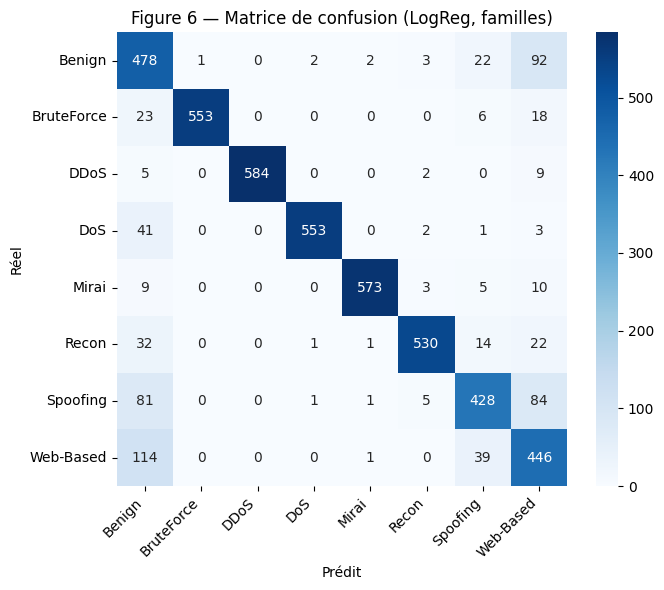

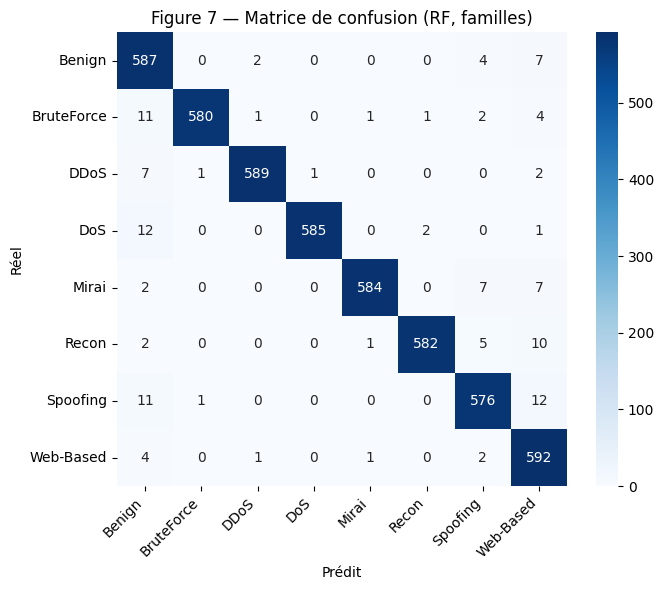

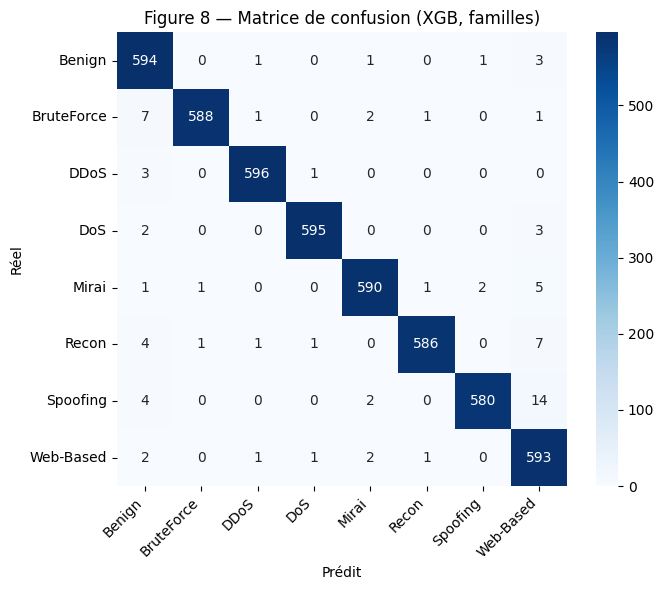

,scenario,title,precision,recall,auprc,balanced_acc,mcc,cm
0,Familles,LogisticRegression,0.881053,0.863542,0.904148,0.863542,0.845212,"[[478, 1, 0, 2, 2, 3, 22, 92], [23, 553, 0, 0,..."
1,Familles,RandomForest,0.974944,0.973958,0.996398,0.973958,0.970322,"[[587, 0, 2, 0, 0, 0, 4, 7], [11, 580, 1, 0, 1..."
2,Familles,XGBoost,0.984121,0.983750,0.998722,0.983750,0.981465,"[[594, 0, 1, 0, 1, 0, 1, 3], [7, 588, 1, 0, 2,..."


In [ ]:
fam_results = []
artifacts = {}



lr = LogisticRegression(max_iter=3000, class_weight="balanced", random_state=RANDOM_STATE)
lr.fit(family_scenario["X_train"], family_scenario["y_train"])
lr_pred = lr.predict(family_scenario["X_test"])
lr_proba = lr.predict_proba(family_scenario["X_test"])


rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced_subsample")
rf.fit(family_scenario["X_train"], family_scenario["y_train"])
rf_pred = rf.predict(family_scenario["X_test"])
rf_proba = rf.predict_proba(family_scenario["X_test"])


xgb_clf = xgb.XGBClassifier(
    n_estimators=800,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    objective="multi:softprob",
    num_class=len(family_scenario["classes"]),
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
xgb_clf.fit(family_scenario["X_train"], family_scenario["y_train"])
xgb_proba = xgb_clf.predict_proba(family_scenario["X_test"])
xgb_pred = np.argmax(xgb_proba, axis=1)




artifacts["lr_pred"] = lr_pred
artifacts["rf_pred"] = rf_pred
artifacts["xgb_pred"] = xgb_pred

fam_results.append(eval(family_scenario["y_test"], lr_pred, y_score=lr_proba, title="LogisticRegression", classes=lr.classes_))
fam_results.append(eval(family_scenario["y_test"], rf_pred, y_score=rf_proba, title="RandomForest", classes=rf.classes_))
fam_results.append(eval(family_scenario["y_test"], xgb_pred, y_score=xgb_proba, title="XGBoost", classes=np.arange(len(family_scenario["classes"]))))
for r in fam_results:
    r["scenario"] = family_scenario["name"]

plot_confusion_matrix(family_scenario["y_test"], artifacts["lr_pred"], class_names=family_scenario["classes"], title="Figure 6 — Matrice de confusion (LogReg, familles)")
plot_confusion_matrix(family_scenario["y_test"], artifacts["rf_pred"], class_names=family_scenario["classes"], title="Figure 7 — Matrice de confusion (RF, familles)")
plot_confusion_matrix(family_scenario["y_test"], artifacts["xgb_pred"], class_names=family_scenario["classes"], title="Figure 8 — Matrice de confusion (XGB, familles)")

fam_df = pd.DataFrame(fam_results)
fam_df = fam_df[["scenario", "title", "precision", "recall", "auprc", "balanced_acc", "mcc"]]
fam_df


## 6B. Partie 2B — Classification multi-classes (sous-types)

Objectif : affiner le suivi d’attaques en passant des familles (≈ 8 classes) aux **sous-types** (`attack_subtype`).

Défis principaux :
- Les sous-types sont plus nombreux et souvent **très déséquilibrés**.
- Split **par fichier** obligatoire (anti-fuite).
- Éviter des classes absentes du train/test : on **filtre/regroupe** les sous-types trop rares.


In [ ]:
st_results = []
artifacts = {}



lr_st = LogisticRegression(max_iter=4000,class_weight="balanced",solver="saga",random_state=RANDOM_STATE)
lr_st.fit(st_scenario["X_train"], st_scenario["y_train"])
lr_pred = lr_st.predict(st_scenario["X_test"])
lr_proba = lr_st.predict_proba(st_scenario["X_test"])


rf_st = RandomForestClassifier(n_estimators=150,n_jobs=-1,random_state=RANDOM_STATE,class_weight="balanced_subsample")
rf_st.fit(st_scenario["X_train"], st_scenario["y_train"])
rf_pred = rf_st.predict(st_scenario["X_test"])
rf_proba = rf_st.predict_proba(st_scenario["X_test"])


xgb_st = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    objective="multi:softprob",
    num_class=len(st_scenario["classes"]),
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
xgb_st.fit(st_scenario["X_train"], st_scenario["y_train"])
xgb_proba = xgb_st.predict_proba(st_scenario["X_test"])
xgb_pred = np.argmax(xgb_proba, axis=1)



artifacts["lr_pred"] = lr_pred
artifacts["rf_pred"] = rf_pred
artifacts["xgb_pred"] = xgb_pred

st_results.append(eval(st_scenario["y_test"], lr_pred, y_score=lr_proba, title="LogisticRegression", classes=lr_st.classes_))
st_results.append(eval(st_scenario["y_test"], rf_pred, y_score=rf_proba, title="RandomForest", classes=rf_st.classes_))
st_results.append(eval(st_scenario["y_test"], xgb_pred, y_score=xgb_proba, title="XGBoost", classes=np.arange(len(st_scenario["classes"]))))
for r in st_results:
    r["scenario"] = st_scenario["name"]

plot_confusion_matrix(st_scenario["y_test"], artifacts["lr_pred"], class_names=st_scenario["classes"], title="Figure 9 — Confusion (LogReg, sous-types)")
plot_confusion_matrix(st_scenario["y_test"], artifacts["rf_pred"], class_names=st_scenario["classes"], title="Figure 10 — Confusion (RF, sous-types)")
plot_confusion_matrix(st_scenario["y_test"], artifacts["xgb_pred"], class_names=st_scenario["classes"], title="Figure 11 — Confusion (XGB, sous-types)")

st_df = pd.DataFrame(st_results)
st_df = st_df[["scenario", "title", "precision", "recall", "auprc", "balanced_acc", "mcc"]]
st_df


TypeError: eval() missing 1 required positional argument: 'y_score'

In [ ]:
fam_table = pd.DataFrame(fam_results)[[
    "title",
    "precision",
    "recall",
    "auprc",
    "balanced_acc",
    "mcc",
]]

st_table = pd.DataFrame(st_results)[[
    "title",
    "precision",
    "recall",
    "auprc",
    "balanced_acc",
    "mcc",
]]

final_table = pd.concat([binary_table, fam_table, st_table], ignore_index=True)
final_table = final_table[[
	"title",
	"precision",
	"recall",
	"auprc",
	"balanced_acc",
	"mcc",
]]
final_table


KeyError: "['precision', 'recall', 'auprc'] not in index"

In [ ]:
def pick_best(df, metric, higher_is_better=True):
    d = df.dropna(subset=[metric]).copy()
    idx = d[metric].idxmax() if higher_is_better else d[metric].idxmin()
    return d.loc[idx]

best_bin = pick_best(binary_table, metric="auprc")
best_fam = pick_best(fam_table, metric="balanced_acc")
best_st = pick_best(st_table, metric="balanced_acc") if "st_table" in globals() else None

rows = []
rows.append({
	"task": "Binaire",
	"best_model": best_bin["title"],
	"metric": "AUPRC",
	"value": float(best_bin["auprc"]),
})
rows.append({
	"task": "Familles",
	"best_model": best_fam["title"],
	"metric": "Balanced Acc",
	"value": float(best_fam["balanced_acc"]),
})
rows.append({
	"task": "Sous-types",
	"best_model": best_st["title"],
	"metric": "Balanced Acc",
	"value": float(best_st["balanced_acc"]),
})

pd.DataFrame(rows)

,task,best_model,metric,value
0,Binaire,Supervisé - XGBoost (CPU hist),AUPRC,0.999995
1,Familles,Multiclass - XGBoost (hist),Balanced Acc,0.983750
2,Sous-types,Subtype - XGBoost (hist),Balanced Acc,0.986661


## 8. Conclusions

Points clés à rapporter :
- Le dataset est déséquilibré (Benign majoritaire), ce qui rend l’AUPRC particulièrement pertinente.
- Le split **par fichier** évite la fuite de données et rend l’évaluation plus crédible.
- Le projet couvre 3 niveaux complémentaires : **détecter** (binaire), **tracker haut niveau** (familles), **tracker fin** (sous-types).


## 8 bis. Conclusions cyber par niveau

**Partie 1 — Binaire (détecter)**
- Identifier le meilleur modèle (souvent XGBoost/RF) selon AUPRC et compromis FP/FN.
- Justifier l’usage des courbes PR (dataset déséquilibré) plutôt que l’accuracy.
- Interpréter les erreurs : faux positifs (alert fatigue) vs faux négatifs (attaques manquées).

**Partie 2A — Familles (tracker haut niveau)**
- Mettre en avant les familles les plus confondues via `top_confusions` et proposer une explication réseau (patterns proches).
- Comparer macro vs weighted : macro reflète l’équité entre familles rares/majoritaires.

**Partie 2B — Sous-types (tracker fin)**
- Montrer l’effet du déséquilibre et l’intérêt du filtrage + regroupement `Other` (évaluation stable, moins de classes fantômes).
- Discuter la limite : plus de granularité = plus de variance / besoin de données par sous-type.
